# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.717459,False,-1.692584
1,-0.361556,False,0.124224
2,0.428248,True,6.760752
3,-0.379635,False,-2.450493
4,-0.430361,True,3.705406
...,...,...,...
995,-0.456266,True,5.822778
996,1.191536,True,9.257252
997,-0.728573,False,-2.211561
998,-0.631663,False,-0.585232


<AxesSubplot: xlabel='v0'>

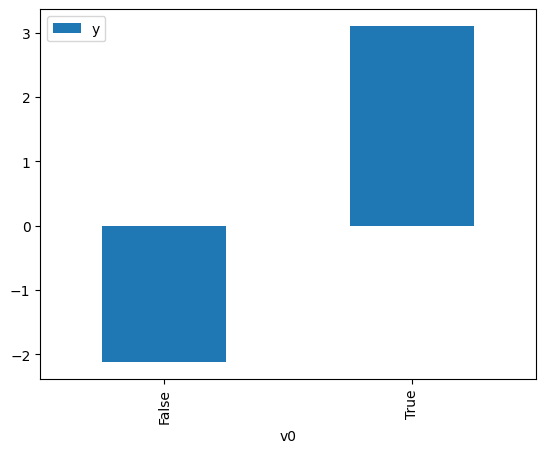

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

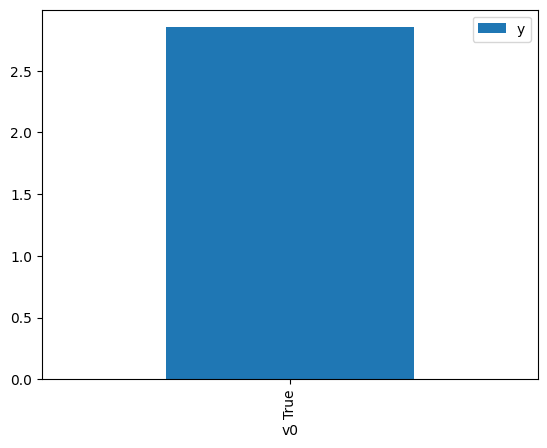

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.712302,False,-5.125201,0.801922,1.247004
1,-0.294576,False,-1.635341,0.558388,1.790869
2,-0.407374,False,-1.443416,0.581081,1.720930
3,0.093182,False,1.120992,0.479096,2.087263
4,-0.971097,False,-1.965397,0.687818,1.453873
...,...,...,...,...,...
995,-0.828097,False,-2.090050,0.662076,1.510401
996,-3.560854,False,-11.282238,0.948618,1.054165
997,-0.640465,False,-2.553929,0.626807,1.595388
998,-0.857967,False,-1.680545,0.667539,1.498039


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.871773,True,2.175955,0.329950,3.030759
1,-1.540266,True,0.832702,0.221467,4.515335
2,0.065539,True,6.514182,0.515239,1.940848
3,-3.176252,True,-2.393652,0.069137,14.463981
4,-2.116389,True,-0.835946,0.150582,6.640879
...,...,...,...,...,...
995,1.021000,True,7.034159,0.699571,1.429448
996,0.065539,True,6.514182,0.515239,1.940848
997,-0.823665,True,3.454207,0.338739,2.952129
998,-1.253909,True,2.667940,0.264622,3.778975


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              8483.
Date:                Thu, 16 Mar 2023   Prob (F-statistic):                        0.00
Time:                        23:22:35   Log-Likelihood:                         -1443.2
No. Observations:                1000   AIC:                                      2890.
Df Residuals:                     998   BIC:                                      2900.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6457      0.025    104.309      0.000       2.596       2.695
x2             5.0352      0.054     92.631      0.000       4.929       5.142
==============================================================================
Omnibus:                        0.207   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.902   Jarque-Bera (JB):                0.251
Skew:                          -0.032   Prob(JB):                        0.882
Kurtosis:                       2.957   Cond. No.                         2.18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""